# Project Luther

#### Back story:

Using information we scrape from the web, can we build linear regression models from which we can learn about either the movie, sports or something else of your choice.

#### Data:

 * **acquisition**: web scraping
 * **storage**: flat files (ex. pickling)
 * **sources**: (as listed below or any other publicly available information)   

#### Skills:

 * basics of the web (requests, HTML, CSS, JavaScript)
 * web scraping
 * `numpy` and `pandas`
 * `statsmodels`, `scikit-learn`


#### Analysis:

 * linear regression is required, other regression methods are optional


#### Deliverable/communication:

 * organized project repository
 * slide presentation
 * visual and oral communication in presentations
 * write-up of process and results


#### Design:

 * iterative design process
 * "MVP"s and building outward


#### More information:

We'll learn about web scraping using two popular tools - BeautifulSoup and Selenium. You'll have to know the very basics of HTML. We'll also be evolving the way we use IPython notebooks—during this project we'll begin to use the notebook as a development scratchpad, where we test things out through interactive scripting, but then solidify our work in python modules with reusable functions and classes.

We'll practice using linear regression. We'll have a first taste of feature selection, this time based on our intuition and some trial and error, and we'll build and refine our models.

We'll work in groups for brainstorming and design, and code sharing will be highly encouraged, but the final projects will be individual.

This project will really give you the freedom to challenge yourself, no matter your skill level. Find your boundaries, meet them, and push them a little further.

We are very excited to see what you will learn and do for Project Luther!

## Project Brainstorm

#### Topic Ideas:

- How weather affects crop yield
    - max/min temperature
    - mean temperature
    - heating degree days
    - cooling degree days
    - growing degree days
    - precipitation
    - wind
    - sea level pressure
- Find crops with a lot of data:
    - corn
    - wheat
    - potato
    - rice
    
    
#### Source:

- Weather data
    - https://www.wunderground.com/history/
    - https://www.ncdc.noaa.gov/
    
    
- Agriculture data
    - https://www.nass.usda.gov/Statistics_by_Subject/
    

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import re

from sklearn.model_selection import train_test_split

%matplotlib inline

--------

# Web scraping data

## Scrape weather data

#### Tools:

- BeautifulSoup to scrape data
- Change up URL for each data point

Get and convert all the urls to pages

In [331]:
#list out all the months/years
years = range(1950,2017)
months = range(1,13)
url_list = []


#iterate through years and months
for y in years:    
    for m in months:
        url = 'https://www.wunderground.com/history/airport/KFAT/' +str(y) + '/' +  str(m) + '/1/MonthlyHistory.html?req_city=Fresno&req_state=CA&req_statename=California&reqdb.zip=93650&reqdb.magic=1&reqdb.wmo=99999'
        url_list.append(url)


In [332]:
#create list of pages to be put into BeautifulSoup a simplified? way
page_list = []
for url in url_list:
    response = requests.get(url)
    page = response.text
    page_list.append(page)

In [333]:
#pickle page_list for faster loading in future
pickle.dump(page_list, open('page_list.p', 'wb'))
df_page_list = pickle.load(open('page_list.p', 'rb'))

Put the pages into BeautifulSoup

Compile weather data for each page

In [856]:
#create a function to extra weather information for each month
def get_weather_data(soup):

    value_list = []
    history_table = soup.find(id = 'historyTable')
    #max_temp = soup.find(id = 'historyTable').find_all('tr')[2]
    history_table_tr = history_table.find_all('tr')
    
    #add date to value_list
    month = soup.find('select', class_='month form-select').find('option', selected='selected')['value']
    year = soup.find('select', class_='year form-select').find('option', selected='selected').text
    value_list.append(year)
    value_list.append(month)
    
    for i in history_table_tr[2:]:
        try:
            if not i.find_all('td')[2].find_all('span'):
                value_list.append(i.find_all('td')[2].text)
            value_list.append(i.find_all('td')[2].find_all('span')[1].text)
        except IndexError:
            pass
    value_list = pd.DataFrame(value_list).T
    value_list.columns = ['Year', 'Month','Max_Temperature', 'Mean_Temperature', 'Min_Temperature', 'Heating_Days', 'Cooling_Days','Growing_Days', 'Dew_Point', 'Precipitation', 'Snowdepth', 'Wind', 'Gust_Wind', 'Sea_Level_Pressure']
    value_list = value_list.replace('\n  -\n', 'NaN')
    return value_list

Now, let's try to build a large dataframe of all weather

In [857]:
frame = []
for i in range(len(df_page_list)):
    try:
        soup = BeautifulSoup(df_page_list[i], 'lxml')
        frame.append(get_weather_data(soup))
    except AttributeError:
        pass

df = pd.concat(frame, ignore_index = True)

In [4]:
#pickle weather data for faster loading

#pickle.dump(df, open('weather.p','wb'))
df_weather = pickle.load(open('weather.p', 'rb'))

In [5]:
df_weather.sample(10)

,Year,Month,Max_Temperature,Mean_Temperature,Min_Temperature,Heating_Days,Cooling_Days,Growing_Days,Dew_Point,Precipitation,Snowdepth,Wind,Gust_Wind,Sea_Level_Pressure
204,1967,1,54,46,37,19,0,1,39,0.03,NaN,5,NaN,30.18
203,1966,12,50,45,41,20,0,1,43,0.03,NaN,5,NaN,30.13
37,1953,2,61,48,35,17,0,1,38,0.00,NaN,6,NaN,30.16
95,1957,12,52,45,38,20,0,0,40,0.06,NaN,4,NaN,30.17
68,1955,9,90,74,58,0,9,24,48,0.00,NaN,5,NaN,29.85
225,1968,10,76,63,50,3,1,13,49,0.01,NaN,5,NaN,29.99
451,1987,8,96,80,64,0,15,30,54,0.00,NaN,6,NaN,29.89
510,1992,7,95,81,67,0,16,31,56,0.01,NaN,9,23,29.90
177,1964,10,83,68,54,1,5,18,50,0.04,NaN,5,NaN,29.98
357,1979,10,80,68,55,2,4,18,50,0.02,NaN,6,24,29.99


In [6]:
#convert the strings to floats
df_w = df_weather.copy()
try:
    df_w= df_w.astype(float)
except ValueError:
    pass

In [7]:
#create new dataframe with data compiled for each year
df_weather_refined = df_w.groupby('Year')['Max_Temperature'].max().reset_index()
df_weather_refined = df_weather_refined.merge(df_w.groupby('Year')['Mean_Temperature'].mean().reset_index(), on='Year')
df_weather_refined = df_weather_refined.merge(df_w.groupby('Year')['Min_Temperature'].min().reset_index(), on='Year')
df_weather_refined = df_weather_refined.merge(df_w.groupby('Year')['Heating_Days'].sum().reset_index(), on='Year')
df_weather_refined = df_weather_refined.merge(df_w.groupby('Year')['Cooling_Days'].sum().reset_index(), on='Year')
df_weather_refined = df_weather_refined.merge(df_w.groupby('Year')['Growing_Days'].sum().reset_index(), on='Year')
df_weather_refined = df_weather_refined.merge(df_w.groupby('Year')['Dew_Point'].sum().reset_index(), on='Year')
df_weather_refined = df_weather_refined.merge(df_w.groupby('Year')['Precipitation'].sum().reset_index(), on='Year')
df_weather_refined = df_weather_refined.merge(df_w.groupby('Year')['Wind'].mean().reset_index(), on='Year')
df_weather_refined = df_weather_refined.merge(df_w.groupby('Year')['Gust_Wind'].mean().reset_index(), on='Year')
df_weather_refined = df_weather_refined.merge(df_w.groupby('Year')['Sea_Level_Pressure'].mean().reset_index(), on='Year')

In [8]:
df_weather_refined 

,Year,Max_Temperature,Mean_Temperature,Min_Temperature,Heating_Days,Cooling_Days,Growing_Days,Dew_Point,Precipitation,Wind,Gust_Wind,Sea_Level_Pressure
0,1950.0,99.0,63.000000,34.0,76.0,55.0,170.0,575.0,0.40,6.416667,NaN,29.994167
1,1951.0,96.0,62.250000,36.0,86.0,53.0,162.0,560.0,0.30,6.500000,NaN,29.981667
2,1952.0,97.0,62.250000,37.0,88.0,57.0,164.0,566.0,0.48,6.250000,NaN,29.992500
3,1953.0,99.0,61.416667,35.0,88.0,46.0,149.0,547.0,0.20,5.916667,NaN,30.019167
4,1954.0,97.0,61.500000,36.0,90.0,46.0,154.0,535.0,0.31,5.500000,20.000000,29.994167
5,1955.0,96.0,60.666667,34.0,98.0,47.0,146.0,515.0,0.46,5.916667,NaN,29.998333
6,1956.0,94.0,61.083333,33.0,95.0,47.0,146.0,526.0,0.19,5.916667,NaN,30.025833
7,1957.0,95.0,61.583333,34.0,90.0,49.0,155.0,544.0,0.34,5.666667,NaN,29.985000
8,1958.0,97.0,63.250000,36.0,80.0,58.0,170.0,562.0,0.51,5.833333,NaN,29.963333
9,1959.0,99.0,63.000000,33.0,74.0,54.0,166.0,522.0,0.22,6.333333,NaN,29.970833


## Scrape population data

#### Tools:

- Scrapy for scrape data (shown in repository)
- Export data to CSV file

In [9]:
df_population = pd.read_csv("population.csv")
df_population.head()

,Year,Population
0,"Jun 1, 2017",325.15 million\n
1,"Jul 1, 2015",320.90 million\n
2,"Jul 1, 2013",316.20 million\n
3,"Jul 1, 2011",311.66 million\n
4,"Jul 1, 2009",306.77 million\n


In [10]:
#clean up year to cut off month/day
df_population['Year'] = df_population['Year'].str.strip().str.split(',').str[1]

#clean up population to numeric
df_population['Population'] = df_population['Population'].str.strip().str.split('m').str[0]

In [11]:
df_population = df_population[df_population['Population']!= 'Population']
df_population.columns = df_population.columns.str.strip()

In [12]:
df_population = df_population.sort_values('Year', ascending = False).reset_index()
df_population['Year'] = df_population['Year'].astype(int)
df_population['Population'] = df_population['Population'].astype(float)
df_population.head()

,index,Year,Population
0,0,2017,325.15
1,60,2016,323.13
2,1,2015,320.90
3,61,2014,318.56
4,2,2013,316.20


## Scrape agriculture data

#### Tools: 

- Selenium to select database
- BeautifulSoup to scrape data

Set up driver and open up base URL with Selenium

Click on "Program" and "Survey" sections

### Corn Scraping

In [13]:
from selenium.common.exceptions import NoSuchElementException

In [644]:
#create function to generate table for specific crop and return URL
def browse_crop(crop):
    
    chromedriver_path = "/Users/kevinzhao/chromedriver"
    driver = webdriver.Chrome(chromedriver_path)
    driver.get('https://quickstats.nass.usda.gov/')
    time.sleep(1)
    
    program_element = driver.find_element_by_xpath('//select[@name = "source_desc"]/option[@value = "SURVEY"]')
    program_element.click()
    time.sleep(3)

    sector_element = driver.find_element_by_xpath('//select[@name = "sector_desc"]/option[@value = "CROPS"]')
    sector_element.click()
    time.sleep(3)

    group_element = driver.find_element_by_xpath('//select[@name = "group_desc"]/option[@value = "FIELD CROPS"]')
    group_element.click()
    time.sleep(3)

    commodity_element = driver.find_element_by_xpath('//select[@name = "commodity_desc"]/option[@value = "%s"]' % crop)
    commodity_element.click()
    time.sleep(5)

    keep_loop = True
    while keep_loop:
        try:
            yield_element = driver.find_element_by_xpath('//select[@name = "statisticcat_desc"]/option[@value = "YIELD"]')
            yield_element.click()
            time.sleep(10)
            keep_loop = False
        except NoSuchElementException:
            time.sleep(5)
            keep_loop = True

    geographic_element = driver.find_element_by_xpath('//select[@name = "agg_level_desc"]/option[@value = "STATE"]')
    geographic_element.click()
    time.sleep(5)

    keep_loop = True
    while keep_loop:
        try:
            state_element = driver.find_element_by_xpath('//select[@name = "state_name"]/option[@value = "CALIFORNIA"]')
            state_element.click()
            time.sleep(5)
            keep_loop = False
        except NoSuchElementException:
            time.sleep(5)
            keep_loop = True

    search = driver.find_element_by_xpath('//button[@name = "SUBMIT"]/span[@class = "dijitReset dijitInline dijitButtonText"]')
    search.click()
    time.sleep(5)

    printable = driver.find_element_by_xpath('//p[@class = "download"]/a[@href = "javascript:printable();"]')
    printable.click()
    time.sleep(5)

    return driver.current_url


In [645]:
corn_url = browse_crop('CORN')

Great! Finished generating the data table, now time to extract the data.

In [649]:
#Clean up crop data to put into dataframe
def get_crop_data(soup):

    value_list = []
    crop_table = soup.find_all('tr')
    
    for i in range(len(crop_table)):
        if i == 0:
            value_list.append(a.text for a in crop_table[i].find_all('th'))
        else:
            try:
                value_list.append(re.sub("[^A-Z 0-9]*", "", b.text) for b in crop_table[i].find_all('td'))
            except IndexError:
                pass
   
    value_list = pd.DataFrame(value_list)
    return value_list

In [650]:
response = requests.get(corn_url)
page = response.text
soup = BeautifulSoup(page, "lxml")

In [651]:
corn_data = get_crop_data(soup)
corn_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
1,CENSUS,2013,YEAR,,STATE,CALIFORNIA,06,,,,...,,,00000000,,CORN,CORN GRAIN IRRIGATED YIELD MEASURED IN BU ACRE,IRRIGATION METHOD PRIMARY,IRRIGATION METHOD PRIMARY GRAVITY,198,
2,CENSUS,2013,YEAR,,STATE,CALIFORNIA,06,,,,...,,,00000000,,CORN,CORN GRAIN IRRIGATED YIELD MEASURED IN BU ACRE,IRRIGATION METHOD PRIMARY,IRRIGATION METHOD PRIMARY PRESSURE,218,
3,CENSUS,2013,YEAR,,STATE,CALIFORNIA,06,,,,...,,,00000000,,CORN,CORN GRAIN IRRIGATED YIELD MEASURED IN BU ACRE,TOTAL,NOT SPECIFIED,199,
4,CENSUS,2013,YEAR,,STATE,CALIFORNIA,06,,,,...,,,00000000,,CORN,CORN SILAGE IRRIGATED YIELD MEASURED IN TONS ...,IRRIGATION METHOD PRIMARY,IRRIGATION METHOD PRIMARY GRAVITY,28,
5,CENSUS,2013,YEAR,,STATE,CALIFORNIA,06,,,,...,,,00000000,,CORN,CORN SILAGE IRRIGATED YIELD MEASURED IN TONS ...,IRRIGATION METHOD PRIMARY,IRRIGATION METHOD PRIMARY PRESSURE,27,
6,CENSUS,2013,YEAR,,STATE,CALIFORNIA,06,,,,...,,,00000000,,CORN,CORN SILAGE IRRIGATED YIELD MEASURED IN TONS ...,TOTAL,NOT SPECIFIED,28,
7,CENSUS,2012,YEAR,,STATE,CALIFORNIA,06,,,,...,,,00000000,,CORN,CORN GRAIN IRRIGATED ENTIRE CROP YIELD MEASUR...,TOTAL,NOT SPECIFIED,177,05
8,CENSUS,2012,YEAR,,STATE,CALIFORNIA,06,,,,...,,,00000000,,CORN,CORN GRAIN IRRIGATED PART OF CROP YIELD MEASU...,TOTAL,NOT SPECIFIED,1691,09
9,CENSUS,2012,YEAR,,STATE,CALIFORNIA,06,,,,...,,,00000000,,CORN,CORN SILAGE IRRIGATED ENTIRE CROP YIELD MEASU...,TOTAL,NOT SPECIFIED,258,04


### Wheat scraping

In [ ]:
wheat_url = browse_crop('WHEAT')

In [ ]:
response = requests.get(wheat_url)
page = response.text
soup = BeautifulSoup(page, "lxml")
wheat_data = get_crop_data(soup)
wheat_data.head(10)

### And finally...Rice scraping

In [ ]:
rice_url = browse_crop('RICE')

In [ ]:
response = requests.get(rice_url)
page = response.text
soup = BeautifulSoup(page, "lxml")
rice_data = get_crop_data(soup)
rice_data.head(10)

--------

## Refining web scraped data for conditions of interest

### Refine Corn data

In [14]:
#make first row the columns
df_corn = corn_data.copy()
df_corn.columns = df_corn.iloc[0]
df_corn = df_corn.iloc[1:]

#filter surveys and year as data
df_corn = df_corn[(df_corn.Program == 'SURVEY') & (df_corn.Period == 'YEAR')].reset_index()

NameError: name 'corn_data' is not defined

In [1055]:
#regex to filter data item
corn_regex = re.compile('YIELD MEASURED IN BU')
df_corn_clean =df_corn[df_corn['Data Item'].str.contains(corn_regex, regex=True)]

In [1056]:
#Find unique Data Item to filter out
df_corn_clean['Data Item'].unique()

array(['CORN GRAIN  YIELD MEASURED IN BU  ACRE',
       'CORN GRAIN  YIELD MEASURED IN BU  NET PLANTED ACRE'], dtype=object)

In [1057]:
#Filter the correct yield data item
df_corn_clean = df_corn_clean[df_corn_clean['Data Item']=='CORN GRAIN  YIELD MEASURED IN BU  ACRE'].reset_index()

In [1058]:
df_corn_clean = df_corn_clean[['Year', 'Value']].astype(int)
df_corn_clean = df_corn_clean.rename(columns={'Value': 'Corn_Grain_Yield'})
df_corn_clean.head()

,Year,Corn_Grain_Yield
0,2016,185
1,2015,157
2,2014,165
3,2013,191
4,2012,180


### Refine wheat data

In [1645]:
#make first row the columns
df_wheat = wheat_data.copy()
df_wheat.columns = df_wheat.iloc[0]
df_wheat = df_wheat.iloc[1:]

#filter surveys and year as data
df_wheat = df_wheat[(df_wheat.Program == 'SURVEY') & (df_wheat.Period == 'YEAR')].reset_index()

In [1646]:
#regex to filter data item
wheat_regex = re.compile('YIELD MEASURED IN BU')
df_wheat_clean =df_wheat[df_wheat['Data Item'].str.contains(wheat_regex, regex=True)]
df_wheat_clean = df_wheat_clean[~df_wheat_clean['Data Item'].str.contains('WINTER')]
df_wheat_clean = df_wheat_clean[~df_wheat_clean['Data Item'].str.contains('SPRING')]
df_wheat_clean = df_wheat_clean[~df_wheat_clean['Data Item'].str.contains('IRRIGATED')]
df_wheat_clean = df_wheat_clean[~df_wheat_clean['Data Item'].str.contains('NONIRRIGATED')].reset_index()

In [1647]:
df_wheat_clean['Data Item'].unique()

array(['WHEAT  YIELD MEASURED IN BU  ACRE',
       'WHEAT  YIELD MEASURED IN BU  NET PLANTED ACRE'], dtype=object)

In [1650]:
df_wheat_clean = df_wheat_clean[df_wheat_clean['Data Item']=='WHEAT  YIELD MEASURED IN BU  ACRE']
df_wheat_clean = df_wheat_clean[['Year', 'Value']].astype(int)
df_wheat_clean = df_wheat_clean.rename(columns={'Value': 'Wheat_Yield'})
df_wheat_clean.head()

,Year,Wheat_Yield
0,2016,797
1,2015,791
2,2014,834
3,2013,825
4,2012,909


-----

## Linking agriculture data to weather data for analysis

### Link corn yield to weather data

In [1781]:
df_corn_weather = df_corn_clean.copy()
df_corn_weather['Year'] = pd.to_numeric(df_corn_weather['Year'], downcast='integer')

df_wheat_weather = df_wheat_clean.copy()
df_wheat_weather['Year'] = pd.to_numeric(df_wheat_weather['Year'], downcast='integer')

Don't forget population!

In [1782]:
df_population = df_population[df_population['Year']>1949]
df_population = df_population[df_population['Year']<2017]

In [1783]:
df_corn_weather = df_corn_weather.merge(df_population, on='Year')
df_corn_weather = df_corn_weather.merge(df_weather_refined, on='Year')

#Create column for years since starting year
df_corn_weather['Years_Since_1950'] = (df_corn_weather['Year'] - 1950).astype(int)

#Drop unnecessary columns
df_corn_weather.drop('Year', 1, inplace=True)
df_corn_weather.drop('Gust_Wind', 1, inplace=True)
df_corn_weather = df_corn_weather.drop(['index'], axis=1)
df_corn_weather = df_corn_weather.sort_values(['Years_Since_1950'], ascending = True).reset_index()

In [1784]:
df_wheat_weather = df_wheat_weather.merge(df_population, on='Year')
df_wheat_weather = df_wheat_weather.merge(df_weather_refined, on='Year')

#Create column for years since starting year
df_wheat_weather['Years_Since_1950'] = (df_wheat_weather['Year'] - 1950).astype(int)

#Drop unnecessary columns
df_wheat_weather.drop('Year', 1, inplace=True)
df_wheat_weather.drop('Gust_Wind', 1, inplace=True)
df_wheat_weather = df_wheat_weather.drop(['index'], axis=1)
df_wheat_weather_copy = df_wheat_weather.sort_values(['Years_Since_1950'], ascending = True).reset_index()


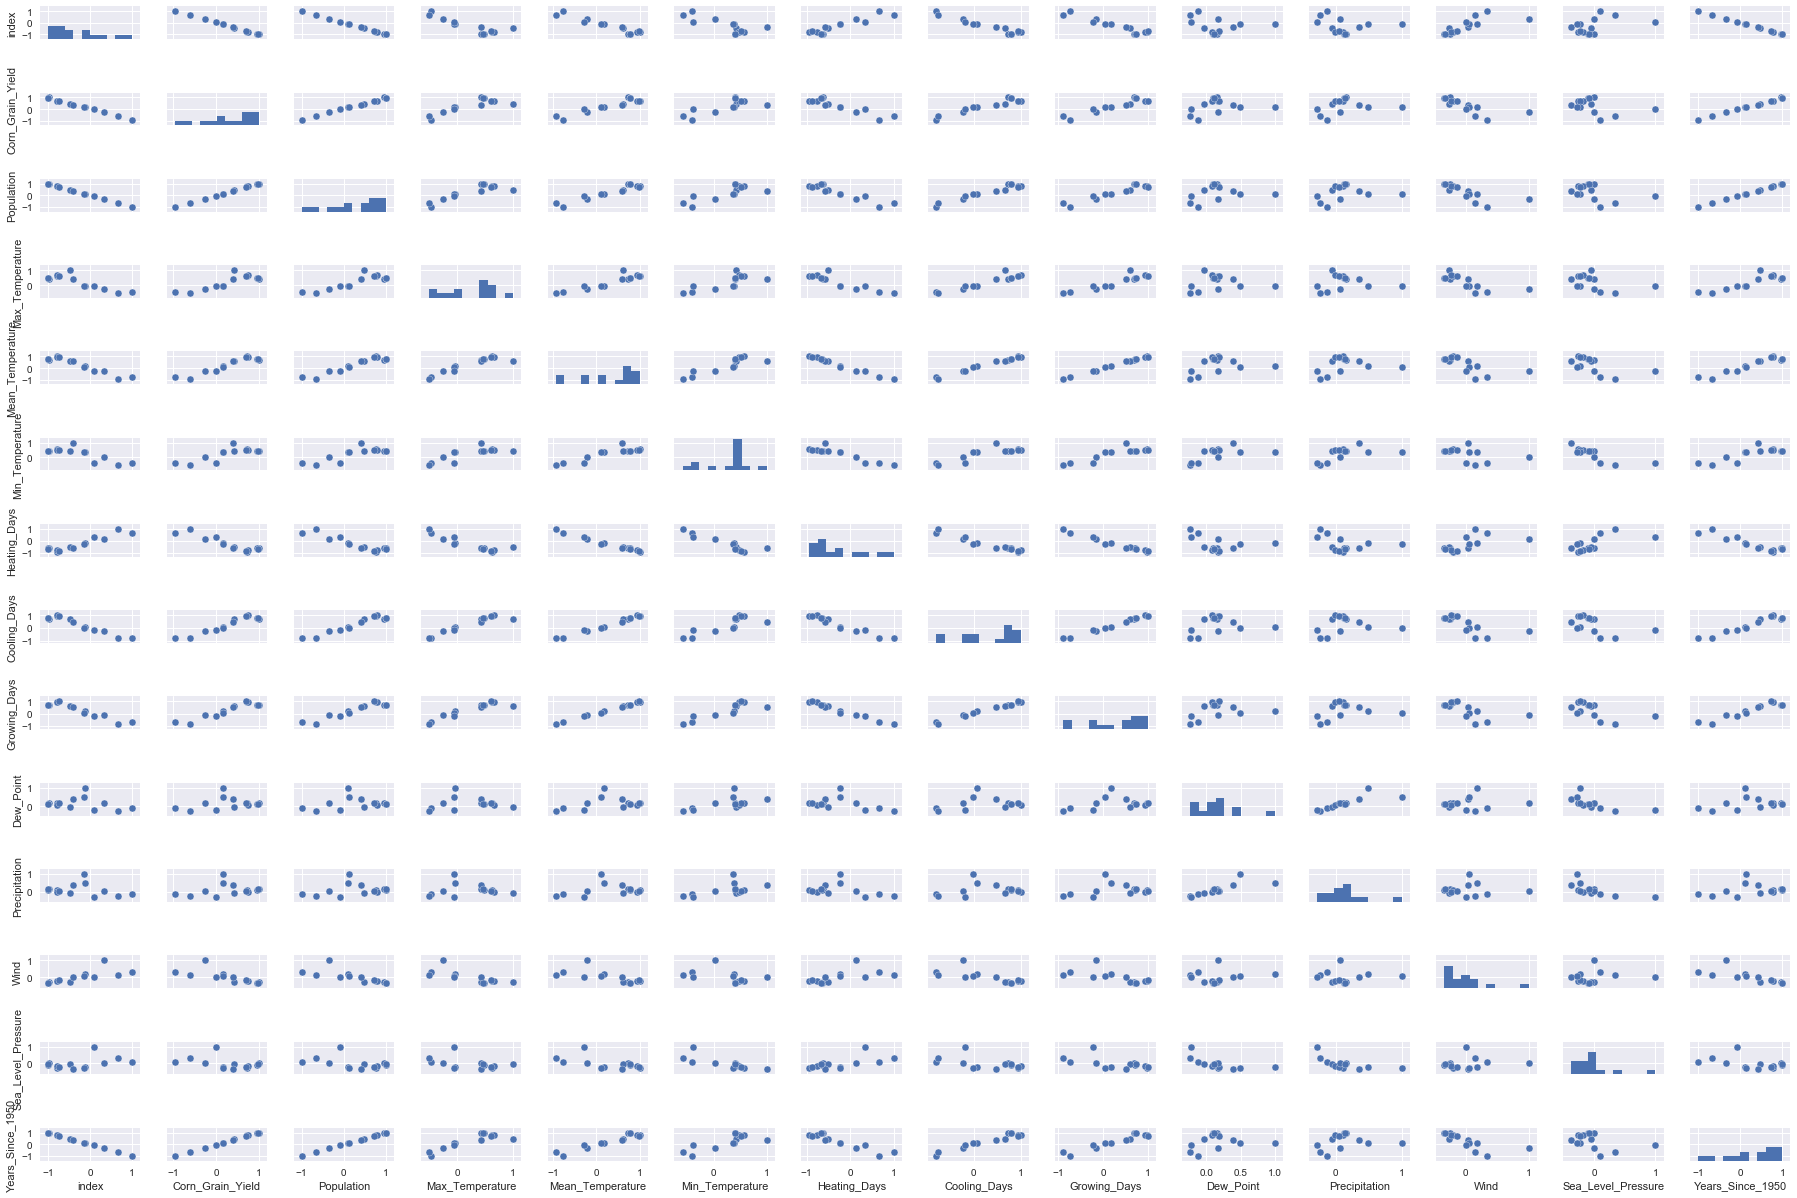

In [1737]:
#Pairplot as an additional tool for strong correlation variables to remove
sns.pairplot(df_corn_weather.corr(), size = 1.2, aspect=1.5)

In [1738]:
df_corn_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 14 columns):
index                 67 non-null int64
Corn_Grain_Yield      67 non-null int64
Population            67 non-null float64
Max_Temperature       67 non-null float64
Mean_Temperature      67 non-null float64
Min_Temperature       67 non-null float64
Heating_Days          67 non-null float64
Cooling_Days          67 non-null float64
Growing_Days          67 non-null float64
Dew_Point             67 non-null float64
Precipitation         67 non-null float64
Wind                  67 non-null float64
Sea_Level_Pressure    67 non-null float64
Years_Since_1950      67 non-null int64
dtypes: float64(11), int64(3)
memory usage: 7.4 KB


In [1739]:
#Correlation of corn variables
df_corn_weather.corr()['Corn_Grain_Yield'].sort_values(ascending=False)

Corn_Grain_Yield      1.000000
Years_Since_1950      0.968567
Population            0.959411
Cooling_Days          0.734577
Mean_Temperature      0.719720
Growing_Days          0.693609
Max_Temperature       0.416388
Min_Temperature       0.397370
Precipitation         0.160883
Dew_Point             0.156290
Sea_Level_Pressure   -0.009980
Wind                 -0.260731
Heating_Days         -0.618304
index                -0.968567
Name: Corn_Grain_Yield, dtype: float64

In [1740]:
#Correlation of wheat variables
df_wheat_weather.corr()['Wheat_Yield'].sort_values(ascending=False)

Wheat_Yield           1.000000
Years_Since_1950      0.727042
Population            0.718168
Cooling_Days          0.593896
Mean_Temperature      0.588853
Growing_Days          0.542434
Max_Temperature       0.380622
Min_Temperature       0.304592
Precipitation         0.121148
Sea_Level_Pressure    0.002448
Dew_Point            -0.009575
Wind                 -0.200274
Heating_Days         -0.512797
index                -0.727042
Name: Wheat_Yield, dtype: float64

Pickle complete dataframes for corn and wheat with weather data

In [15]:
#pickle.dump(df_corn_weather, open('df_corn_weather.p', 'wb'))
df_corn_weather = pickle.load(open('df_corn_weather.p', 'rb'))

In [16]:
#pickle.dump(df_wheat_weather_copy, open('df_wheat_weather.p', 'wb'))
df_wheat_weather = pickle.load(open('df_wheat_weather.p', 'rb'))

-------

## Build linear regression models

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import patsy

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Wheat Model

In [21]:
df_wheat_weather = df_wheat_weather.iloc[:,1:]

In [105]:
X_train, X_test, y_train, y_test = train_test_split(df_wheat_weather.iloc[:,1:], df_wheat_weather.iloc[:,0], test_size=0.2)

In [106]:
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.44112083505247035

In [107]:
#OLS regression results for wheat yield
lsm = smf.ols('Wheat_Yield ~ Years_Since_1950 + Population + Cooling_Days + Mean_Temperature + Growing_Days + Max_Temperature + Min_Temperature + Precipitation + Sea_Level_Pressure + Dew_Point + Wind + Heating_Days',data=df_wheat_weather )
fit1 = lsm.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Wheat_Yield   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     7.200
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           1.25e-07
Time:                        11:04:40   Log-Likelihood:                -446.93
No. Observations:                  67   AIC:                             919.9
Df Residuals:                      54   BIC:                             948.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.566e+04   7.44e+04      0.345      0.731   -1.23e+05    1.75e+05
Years_Since_1950     103.2986     37.059      2.787      0.007      28.999     177.598
Population           -36.5654     14.357     -2.547      0.014     -65.349      -7.782
Cooling_Days           0.5107     23.364      0.022      0.983     -46.331      47.352
Mean_Temperature     270.8562    238.683      1.135      0.261    -207.675     749.387
Growing_Days         -20.5288     12.292     -1.670      0.101     -45.173       4.115
Max_Temperature        2.4501     18.250      0.134      0.894     -34.140      39.040
Min_Temperature       -9.9420     14.089     -0.706      0.483     -38.189      18.305
Precipitation         53.4674    106.408      0.502      0.617    -159.868     266.803
Sea_Level_Pressure -1081.9046   2454.315     -0.441      0.661   -6002.511    3838.702
Dew_Point             -3.3397      1.983     -1.684      0.098      -7.315       0.636
Wind                  35.3487     63.306      0.558      0.579     -91.571     162.269
Heating_Days           7.7971     20.415      0.382      0.704     -33.133      48.727
==============================================================================
Omnibus:                       20.865   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.894
Skew:                          -1.377   Prob(JB):                     1.45e-06
Kurtosis:                       4.433   Cond. No.                     1.85e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [108]:
#Cross validate to see R-squared for predicting future inputs
model1 = LinearRegression()
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
y = df_wheat_weather.iloc[:,0]
X = df_wheat_weather.iloc[:,1:]
scores = cross_val_score(model1, X, y, cv=cross_valiator)

np.round(scores.mean(), 2)

0.28000000000000003

R-squared is significantly lower with CV... let's remove some variables

In [118]:
df_wheat_weather2 = df_wheat_weather.drop(['Cooling_Days', 'Max_Temperature', 'Min_Temperature', 'Precipitation', 'Sea_Level_Pressure', 'Wind', 'Heating_Days'], 1)
lsm2 = smf.ols('Wheat_Yield ~ Years_Since_1950 + Population + Mean_Temperature + Growing_Days + Dew_Point',data=df_wheat_weather2 )
fit2 = lsm2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Wheat_Yield   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     18.68
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           3.28e-11
Time:                        11:17:14   Log-Likelihood:                -447.83
No. Observations:                  67   AIC:                             907.7
Df Residuals:                      61   BIC:                             920.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -444.4157   3820.125     -0.116      0.908   -8083.228    7194.397
Years_Since_1950    94.8087     28.194      3.363      0.001      38.431     151.187
Population         -33.0192     10.992     -3.004      0.004     -54.999     -11.039
Mean_Temperature   157.2617     80.010      1.966      0.054      -2.728     317.252
Growing_Days       -14.4012      7.752     -1.858      0.068     -29.903       1.100
Dew_Point           -3.3086      1.486     -2.227      0.030      -6.279      -0.338
==============================================================================
Omnibus:                       22.608   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.520
Skew:                          -1.441   Prob(JB):                     2.36e-07
Kurtosis:                       4.619   Cond. No.                     9.71e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [119]:
model2 = LinearRegression()
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
y = df_wheat_weather2.iloc[:,0]
X = df_wheat_weather2.iloc[:,1:]
scores = cross_val_score(model2, X, y, cv=cross_valiator)

np.round(scores.mean(), 2)

0.41999999999999998

So much better! But still not good enough...let's plot the correlation of variables

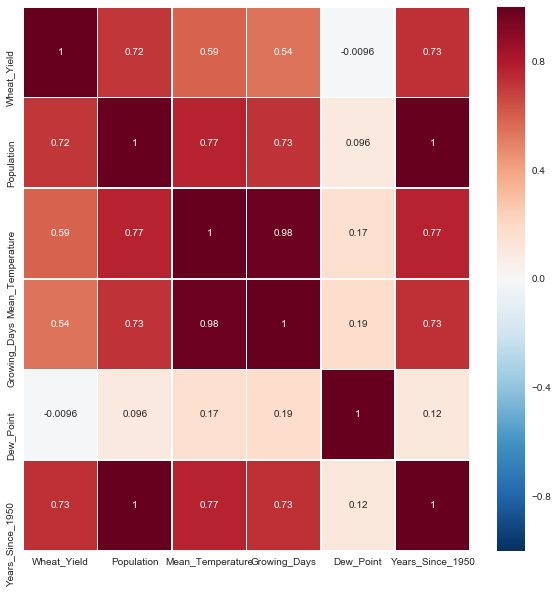

In [120]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_wheat_weather2.corr(),annot=True,linewidth=0.5, ax=ax)

Extremely high correlation between Years_Since_1950 and Population...let's remove Years_Since_1950 variable

In [121]:
df_wheat_weather3 = df_wheat_weather2.drop(['Population'], 1)
lsm3 = smf.ols('Wheat_Yield ~ Years_Since_1950 + Mean_Temperature + Growing_Days + Dew_Point', data=df_wheat_weather3 )
fit3 = lsm3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Wheat_Yield   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     18.67
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           4.08e-10
Time:                        11:17:23   Log-Likelihood:                -452.45
No. Observations:                  67   AIC:                             914.9
Df Residuals:                      62   BIC:                             925.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3089.1987   3950.488     -0.782      0.437    -1.1e+04    4807.714
Years_Since_1950    10.3412      2.183      4.737      0.000       5.977      14.705
Mean_Temperature    84.1406     80.999      1.039      0.303     -77.774     246.055
Growing_Days        -6.9253      7.802     -0.888      0.378     -22.522       8.672
Dew_Point           -1.5997      1.458     -1.097      0.277      -4.515       1.316
==============================================================================
Omnibus:                       12.488   Durbin-Watson:                   1.513
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.023
Skew:                          -0.989   Prob(JB):                      0.00149
Kurtosis:                       3.867   Cond. No.                     8.75e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [223]:
model3 = LinearRegression()
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
y = df_wheat_weather3.iloc[:,0]
X = df_wheat_weather3.iloc[:,1:]
scores = cross_val_score(model3, X, y, cv=cross_valiator)

np.round(scores.mean(), 2)

0.39000000000000001

Worse score but Prob(Omnibus) and Prob(JB) improved, so better normality...remove more variables!

In [217]:
df_wheat_weather4 = df_wheat_weather3.drop(['Growing_Days'], 1)
lsm4 = smf.ols('Wheat_Yield ~ Years_Since_1950 + Mean_Temperature + Dew_Point', data=df_wheat_weather4 )
fit4 = lsm4.fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Wheat_Yield   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     24.72
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           1.09e-10
Time:                        12:55:59   Log-Likelihood:                -452.88
No. Observations:                  67   AIC:                             913.8
Df Residuals:                      63   BIC:                             922.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          114.8029   1602.142      0.072      0.943   -3086.822    3316.428
Years_Since_1950    10.6939      2.143      4.990      0.000       6.412      14.976
Mean_Temperature    15.5859     24.354      0.640      0.525     -33.082      64.254
Dew_Point           -1.7211      1.450     -1.187      0.240      -4.618       1.176
==============================================================================
Omnibus:                       15.331   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.231
Skew:                          -1.120   Prob(JB):                     0.000181
Kurtosis:                       4.076   Cond. No.                     3.39e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [218]:
model4 = LinearRegression()
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
y = df_wheat_weather4.iloc[:,0]
X = df_wheat_weather4.iloc[:,1:]
scores = cross_val_score(model4, X, y, cv=cross_valiator)

np.round(scores.mean(), 2)

0.40000000000000002

Better than Model3 but normality is worse again

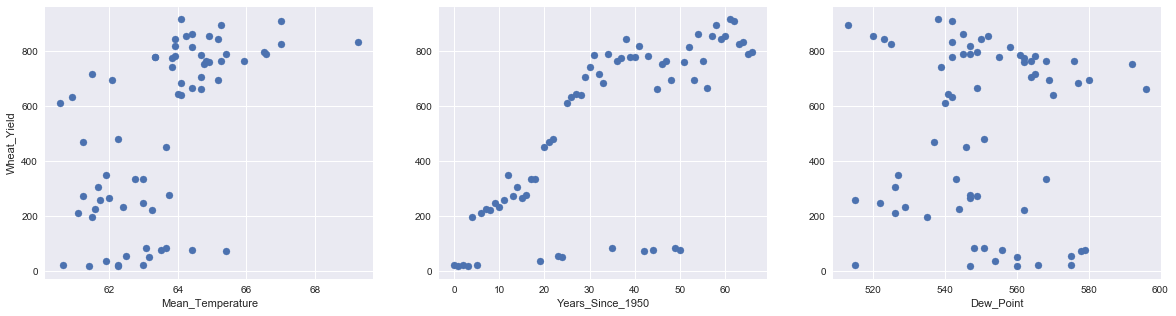

In [224]:
#Scatter plot of Years_Since_1950 vs Wheat_Yield
plt.subplots(1,3,figsize=(20,5))
plt.subplot(131)
plt.scatter(df_wheat_weather['Mean_Temperature'], df_wheat_weather['Wheat_Yield'])
plt.ylabel('Wheat_Yield')
plt.xlabel('Mean_Temperature')
plt.subplot(132)
plt.scatter(df_wheat_weather['Years_Since_1950'], df_wheat_weather['Wheat_Yield'])
plt.xlabel('Years_Since_1950')
plt.subplot(133)
plt.scatter(df_wheat_weather['Dew_Point'], df_wheat_weather['Wheat_Yield'])
plt.xlabel('Dew_Point')

Looks a little bit logarithmic..let's log('Years_Since_1950')

In [225]:
df_wheat_weather5 = df_wheat_weather4.copy()
df_wheat_weather5['Years_Since_1950'] = df_wheat_weather5['Years_Since_1950'] + 1
df_wheat_weather5['log_Years_Since_1950'] = np.log(df_wheat_weather5['Years_Since_1950'])
df_wheat_weather5 = df_wheat_weather5.drop(['Years_Since_1950'], 1)

In [226]:
lsm5 = smf.ols('Wheat_Yield ~ log_Years_Since_1950 + Mean_Temperature + Dew_Point', data=df_wheat_weather5 )
fit5 = lsm5.fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Wheat_Yield   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     26.30
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           3.77e-11
Time:                        12:59:23   Log-Likelihood:                -451.74
No. Observations:                  67   AIC:                             911.5
Df Residuals:                      63   BIC:                             920.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1847.6398   1324.180     -1.395      0.168   -4493.802     798.522
log_Years_Since_1950   196.4173     37.154      5.287      0.000     122.171     270.664
Mean_Temperature        43.6391     19.676      2.218      0.030       4.319      82.959
Dew_Point               -1.9164      1.425     -1.345      0.183      -4.764       0.931
==============================================================================
Omnibus:                       20.075   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.287
Skew:                          -1.362   Prob(JB):                     3.23e-06
Kurtosis:                       4.281   Cond. No.                     2.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [227]:
model5 = LinearRegression()
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
y = df_wheat_weather5.iloc[:,0]
X = df_wheat_weather5.iloc[:,1:]
scores = cross_val_score(model5, X, y, cv=cross_valiator)

np.round(scores.mean(), 2)

0.40000000000000002

No difference... let's try log of Mean_Temperature

In [228]:
df_wheat_weather6 = df_wheat_weather4.copy()
df_wheat_weather6['log_Mean_Temperature'] = np.log(df_wheat_weather6['Mean_Temperature'])
df_wheat_weather6 = df_wheat_weather6.drop(['Mean_Temperature'], 1)

In [229]:
lsm6 = smf.ols('Wheat_Yield ~ Years_Since_1950 + log_Mean_Temperature + Dew_Point', data=df_wheat_weather6 )
fit6 = lsm6.fit()
fit6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Wheat_Yield   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     24.73
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           1.08e-10
Time:                        12:59:47   Log-Likelihood:                -452.87
No. Observations:                  67   AIC:                             913.7
Df Residuals:                      63   BIC:                             922.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -3132.2000   6373.854     -0.491      0.625   -1.59e+04    9604.931
Years_Since_1950        10.6666      2.147      4.969      0.000       6.377      14.957
log_Mean_Temperature  1022.5651   1562.425      0.654      0.515   -2099.691    4144.821
Dew_Point               -1.7335      1.451     -1.194      0.237      -4.634       1.167
==============================================================================
Omnibus:                       15.332   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.233
Skew:                          -1.120   Prob(JB):                     0.000181
Kurtosis:                       4.076   Cond. No.                     1.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [231]:
model6 = LinearRegression()
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
y = df_wheat_weather6.iloc[:,0]
X = df_wheat_weather6.iloc[:,1:]
scores = cross_val_score(model6, X, y, cv=cross_valiator)

np.round(scores.mean(), 2)

0.40000000000000002

Performed similarly to Model 5..maybe remove Mean_Temperature all together because of high p-value

In [237]:
df_wheat_weather7 = df_wheat_weather4.copy()
df_wheat_weather7 = df_wheat_weather7.drop(['Mean_Temperature'], 1)

lsm7 = smf.ols('Wheat_Yield ~ Years_Since_1950 + Dew_Point', data=df_wheat_weather7 )
fit7 = lsm7.fit()
fit7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Wheat_Yield   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     37.21
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           1.90e-11
Time:                        13:02:57   Log-Likelihood:                -453.09
No. Observations:                  67   AIC:                             912.2
Df Residuals:                      64   BIC:                             918.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1007.2639    785.092      1.283      0.204    -561.138    2575.666
Years_Since_1950    11.7493      1.362      8.626      0.000       9.028      14.470
Dew_Point           -1.6046      1.431     -1.121      0.266      -4.464       1.255
==============================================================================
Omnibus:                       16.971   Durbin-Watson:                   1.607
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.017
Skew:                          -1.173   Prob(JB):                     4.50e-05
Kurtosis:                       4.292   Cond. No.                     1.66e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [238]:
model7 = LinearRegression()
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
y = df_wheat_weather7.iloc[:,0]
X = df_wheat_weather7.iloc[:,1:]
scores = cross_val_score(model7, X, y, cv=cross_valiator)

np.round(scores.mean(), 2)

0.42999999999999999

Highest score so far! Let's work on refining this model

### Normalization and regularization

In [362]:
#Normalize variables for model 4
wheat_trans = preprocessing.normalize(df_wheat_weather4, axis =0)

wheat_trans=pd.DataFrame(wheat_trans,columns=df_wheat_weather4.columns)

y_trans = wheat_trans['Wheat_Yield']
X_trans = wheat_trans.drop(['Wheat_Yield'],1)

#### Ridge regularization

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


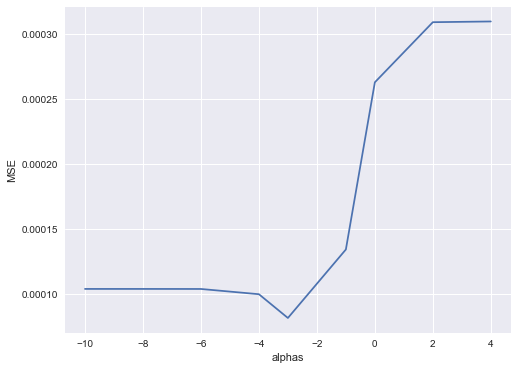

In [243]:
#Find alpha with lowest MSE
alphas=[1e-10,1e-8,1e-6,1e-4,1e-3,1e-1,1,100,10000]
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.3)

def make_estimator(est,alpha):
    est.alpha=alpha
    model = est.fit(X_train,y_train)
    mse=np.mean(y_test-model.predict(X_test))**2
    return mse
   
# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [244]:
#find score with this alpha
reg1 = Ridge(alpha = 1e-3)
reg1.fit(X_train, y_train)
reg1.score(X_test, y_test)

0.4570979637079684

In [363]:
#find cross validation score with Ridge
rcv = RidgeCV(alphas=(1e-4, 1e-3, 1e-2), cv=5)
rcv.fit(X_trans, y_trans)
rcv.score(X_trans, y_trans)

0.536658219519627

#### Lasso Regularization

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


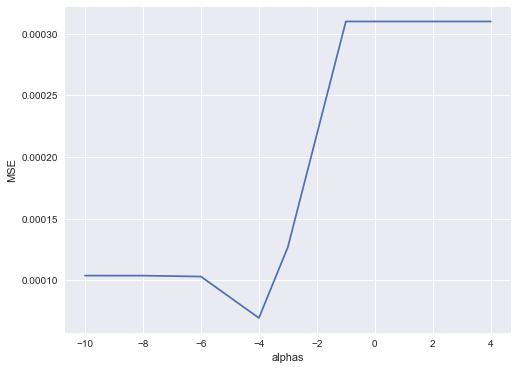

In [246]:
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Lasso(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [247]:
#find score with this alpha
reg2 = Lasso(alpha = 1e-4)
reg2.fit(X_train, y_train)
reg2.score(X_test, y_test)

0.45890688526508916

In [336]:
#find cross validation score with Lasso
lcv = LassoCV(alphas=(1e-4, 1e-3, 1e-2), cv=5)
lcv.fit(X_trans, y_trans)
lcv.score(X_trans, y_trans)

0.52793092803079522

#### Elastic Net

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


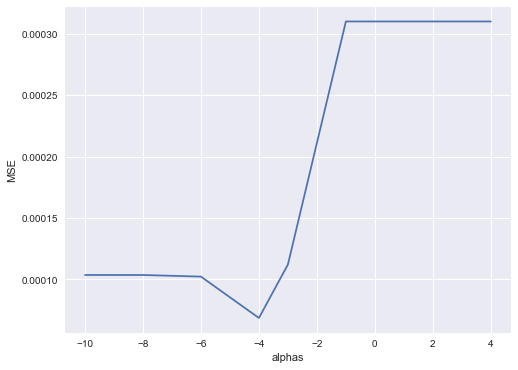

In [249]:
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(ElasticNet(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [250]:
#find score with this alpha
reg3 = ElasticNet(alpha = 1e-4)
reg3.fit(X_train, y_train)
reg3.score(X_test, y_test)

0.45760086380730891

In [337]:
#find cross validation score with Elastic Net
ecv = ElasticNetCV(alphas=(1e-4, 1e-3, 1e-2), cv=5)
ecv.fit(X_trans, y_trans)
ecv.score(X_trans, y_trans)

0.52810298928220245

#### Ridge performed the best! Lasso and Elastic Net also good and performed similarly

In [338]:
#print intercept and coefficients of Ridge
print(rcv.intercept_, rcv.coef_)

0.0802475492312 [ 0.35492375 -0.78579313  0.73055977]


In [339]:
#put coefficients in dataframe
zipped = zip(X_trans.columns, rcv.coef_)
features = sorted(zipped, key = lambda t:t[1], reverse=True)
features

[('Years_Since_1950', 0.7305597660649259),
 ('Mean_Temperature', 0.35492374918773806),
 ('Dew_Point', -0.7857931335571714)]

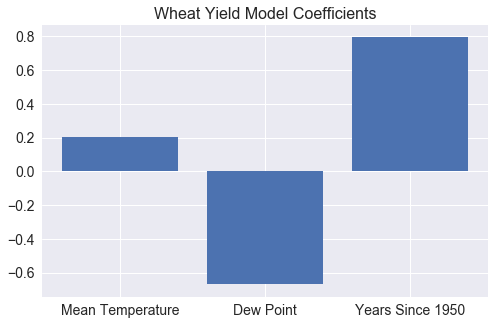

In [509]:
#plot a bar graph of the coefficients
name = [1, 2, 3]
name_trans = ['Mean Temperature', 'Dew Point', 'Years Since 1950']
coefficients = reg1.coef_
plt.subplots(1, 1, figsize=(8,5))
plt.bar(name, coefficients)
plt.xticks(name, name_trans, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Wheat Yield Model Coefficients', fontsize=16)
plt.show()

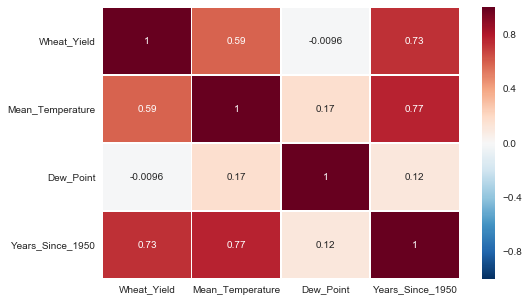

In [511]:
#Heat map of variable correlations
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(wheat_trans.corr(),annot=True,linewidth=0.5, ax=ax)

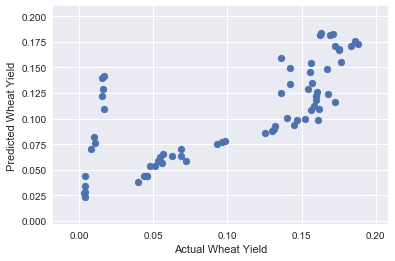

In [364]:
#Plot actual vs predict wheat yield
plt.scatter(y_trans,rcv.predict(X_trans));
plt.xlabel('Actual Wheat Yield');
plt.ylabel('Predicted Wheat Yield');

#### Start plotting individual variables against wheat yield

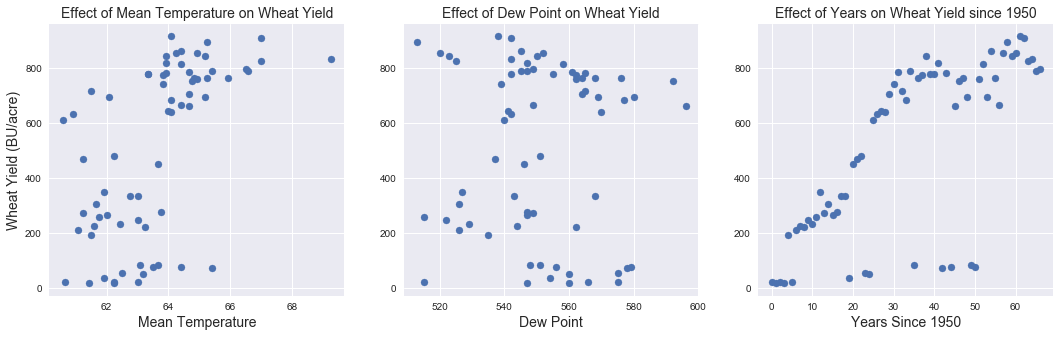

In [518]:
#Plot Wheat Yield vs features
plt.subplots(1,3,figsize=(18,5));
plt.subplot(131)
plt.scatter(df_wheat_weather4['Mean_Temperature'], df_wheat_weather4['Wheat_Yield'])
plt.xlabel('Mean Temperature',fontsize=14)
plt.ylabel('Wheat Yield (BU/acre)',fontsize=14)
plt.title('Effect of Mean Temperature on Wheat Yield', fontsize=14)
plt.subplot(132)
plt.scatter(df_wheat_weather4['Dew_Point'], df_wheat_weather4['Wheat_Yield'])
plt.xlabel('Dew Point', fontsize=14)
plt.title('Effect of Dew Point on Wheat Yield', fontsize=14)
plt.subplot(133)
plt.scatter(df_wheat_weather4['Years_Since_1950'], df_wheat_weather4['Wheat_Yield'])
plt.xlabel('Years Since 1950', fontsize=14)
plt.title('Effect of Years on Wheat Yield since 1950', fontsize=14);

Strong linear correlation for Years and Wheat Yield, but some randomness with correlation for Mean Temperature and Dew Point

-----

## Corn Model

Initial model with all the variables

In [298]:
#Fit model with statsmodels
df_corn_weather = df_corn_weather.iloc[:,1:]
lsm = smf.ols('Corn_Grain_Yield ~ Population + Years_Since_1950 + Cooling_Days + Mean_Temperature + Growing_Days + Max_Temperature+ Min_Temperature + Precipitation + Dew_Point + Sea_Level_Pressure + Wind + Heating_Days', data=df_corn_weather)
fit1 = lsm.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Corn_Grain_Yield   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     134.3
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           1.07e-35
Time:                        15:37:48   Log-Likelihood:                -234.18
No. Observations:                  67   AIC:                             494.4
Df Residuals:                      54   BIC:                             523.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            883.9069   3107.067      0.284      0.777   -5345.388    7113.202
Population            -2.5888      0.600     -4.316      0.000      -3.791      -1.386
Years_Since_1950       9.1297      1.548      5.896      0.000       6.025      12.234
Cooling_Days          -1.6573      0.976     -1.698      0.095      -3.614       0.300
Mean_Temperature       2.1749      9.973      0.218      0.828     -17.819      22.169
Growing_Days           1.0110      0.514      1.968      0.054      -0.019       2.041
Max_Temperature        0.1471      0.763      0.193      0.848      -1.382       1.676
Min_Temperature        0.5892      0.589      1.001      0.321      -0.591       1.769
Precipitation          1.9646      4.446      0.442      0.660      -6.949      10.878
Dew_Point             -0.1181      0.083     -1.426      0.160      -0.284       0.048
Sea_Level_Pressure   -23.6418    102.545     -0.231      0.819    -229.232     181.949
Wind                   0.7994      2.645      0.302      0.764      -4.504       6.102
Heating_Days           0.9979      0.853      1.170      0.247      -0.712       2.708
==============================================================================
Omnibus:                       29.847   Durbin-Watson:                   0.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.650
Skew:                          -1.430   Prob(JB):                     2.04e-15
Kurtosis:                       7.006   Cond. No.                     1.85e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [299]:
#Find cross validation score for ability to predict future variables
c_model = LinearRegression()
y = df_corn_weather.iloc[:, 0]
X = df_corn_weather.iloc[:, 1:]
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(c_model, X, y, cv=cross_valiator)
np.round(scores.mean(), 2)

0.93999999999999995

Extremely high R2 value...let's remove some variables

In [300]:
df_corn_weather2 = df_corn_weather.drop(['Mean_Temperature', 'Max_Temperature', 'Min_Temperature', 'Precipitation', 'Sea_Level_Pressure', 'Wind'], 1)
lsm2 = smf.ols('Corn_Grain_Yield ~ Population + Years_Since_1950 + Cooling_Days + Growing_Days + Dew_Point + Heating_Days', data=df_corn_weather2)
fit2 = lsm2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Corn_Grain_Yield   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     285.9
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           3.42e-42
Time:                        15:37:56   Log-Likelihood:                -235.57
No. Observations:                  67   AIC:                             485.1
Df Residuals:                      60   BIC:                             500.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          364.0731    118.427      3.074      0.003     127.184     600.962
Population          -2.5515      0.456     -5.591      0.000      -3.464      -1.639
Years_Since_1950     9.0010      1.171      7.686      0.000       6.659      11.343
Cooling_Days        -1.1639      0.505     -2.306      0.025      -2.174      -0.154
Growing_Days         0.7614      0.408      1.866      0.067      -0.055       1.578
Dew_Point           -0.0593      0.066     -0.904      0.370      -0.190       0.072
Heating_Days         0.5686      0.286      1.988      0.051      -0.004       1.141
==============================================================================
Omnibus:                       31.605   Durbin-Watson:                   0.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.398
Skew:                          -1.466   Prob(JB):                     5.74e-18
Kurtosis:                       7.455   Cond. No.                     7.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [301]:
#Cross validate the score
c_model2 = LinearRegression()
y = df_corn_weather2.iloc[:, 0]
X = df_corn_weather2.iloc[:,1:]
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
scores2 = cross_val_score(c_model2, X, y, cv=cross_valiator)
np.round(scores2.mean(), 2)

0.94999999999999996

Still unusually high number..remove Dew_Point

In [302]:
df_corn_weather3 = df_corn_weather2.drop(['Dew_Point'], 1)
lsm3 = smf.ols('Corn_Grain_Yield ~ Population + Years_Since_1950 + Cooling_Days + Growing_Days + Heating_Days', data=df_corn_weather3)
fit3 = lsm3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Corn_Grain_Yield   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     343.9
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           2.62e-43
Time:                        15:38:14   Log-Likelihood:                -236.02
No. Observations:                  67   AIC:                             484.0
Df Residuals:                      61   BIC:                             497.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          314.8715    105.023      2.998      0.004     104.864     524.878
Population          -2.4121      0.429     -5.624      0.000      -3.270      -1.554
Years_Since_1950     8.6324      1.096      7.875      0.000       6.441      10.824
Cooling_Days        -1.0669      0.493     -2.166      0.034      -2.052      -0.082
Growing_Days         0.7015      0.402      1.745      0.086      -0.102       1.506
Heating_Days         0.5674      0.286      1.987      0.051      -0.004       1.139
==============================================================================
Omnibus:                       28.491   Durbin-Watson:                   1.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.595
Skew:                          -1.328   Prob(JB):                     2.10e-15
Kurtosis:                       7.143   Cond. No.                     3.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [303]:
#Cross validate the score
c_model3 = LinearRegression()
X = df_corn_weather3.iloc[:,1:]
y = df_corn_weather3.iloc[:,0]

cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
scores3 = cross_val_score(c_model3, X, y, cv=cross_valiator)
np.round(scores3.mean(), 2)

0.94999999999999996

Still unusually high score... check correlation heatmap

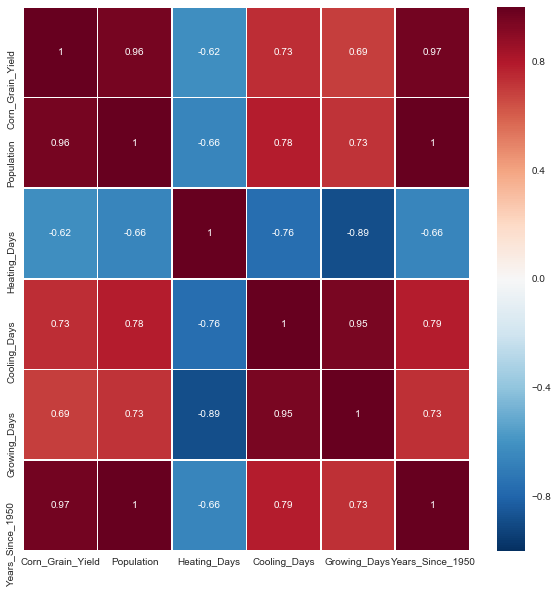

In [304]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_corn_weather3.corr(),annot=True , linewidth=0.5, ax=ax)

Population/Years_Since_1950 and Growing/Cooling/Heating Days are highly correlated....remove them

In [314]:
df_corn_weather4 = df_corn_weather3.drop(['Population', 'Heating_Days', 'Cooling_Days'],1)
lsm4 = smf.ols('Corn_Grain_Yield ~ Years_Since_1950 + Growing_Days', data=df_corn_weather4)
fit4 = lsm4.fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Corn_Grain_Yield   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     489.5
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           1.63e-39
Time:                        15:45:31   Log-Likelihood:                -255.54
No. Observations:                  67   AIC:                             517.1
Df Residuals:                      64   BIC:                             523.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           68.3237     18.873      3.620      0.001      30.620     106.027
Years_Since_1950     2.2741      0.104     21.846      0.000       2.066       2.482
Growing_Days        -0.0892      0.121     -0.737      0.464      -0.331       0.153
==============================================================================
Omnibus:                       10.281   Durbin-Watson:                   0.648
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.341
Skew:                          -0.571   Prob(JB):                     0.000769
Kurtosis:                       4.958   Cond. No.                     2.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [312]:
#Cross validate the score
c_model4 = LinearRegression()
X = df_corn_weather4.iloc[:,1:]
y = df_corn_weather4.iloc[:,0]

cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(c_model4, X, y, cv=cross_valiator)
np.round(scores.mean(), 2)

0.91000000000000003

Score is lower but normality is improving.. score is still relatively high.

Let's see if removing Growing_Days helps the model

In [316]:
df_corn_weather5 = df_corn_weather4.drop(['Growing_Days'],1)
lsm5 = smf.ols('Corn_Grain_Yield ~ Years_Since_1950', data=df_corn_weather5)
fit5 = lsm5.fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Corn_Grain_Yield   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     985.5
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           5.40e-41
Time:                        15:49:22   Log-Likelihood:                -255.83
No. Observations:                  67   AIC:                             515.7
Df Residuals:                      65   BIC:                             520.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           54.5544      2.702     20.187      0.000      49.157      59.952
Years_Since_1950     2.2179      0.071     31.392      0.000       2.077       2.359
==============================================================================
Omnibus:                       14.008   Durbin-Watson:                   0.628
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.726
Skew:                          -0.750   Prob(JB):                     1.92e-05
Kurtosis:                       5.352   Cond. No.                         75.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [317]:
c_model5 = LinearRegression()
X = df_corn_weather5.iloc[:,1:]
y = df_corn_weather5.iloc[:,0]

cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(c_model5, X, y, cv=cross_valiator)
np.round(scores.mean(), 2)

0.92000000000000004

All models have very high R2, but Model 3 performed the best..let's refine that

### Normalization and Regularization

In [467]:
#normalize data from df_corn_weather3
corn_trans = preprocessing.normalize(df_corn_weather3, axis =0)

corn_trans=pd.DataFrame(corn_trans,columns=df_corn_weather3.columns)

y_trans = corn_trans['Corn_Grain_Yield']
X_trans = corn_trans.drop(['Corn_Grain_Yield'],1)

#### Ridge

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


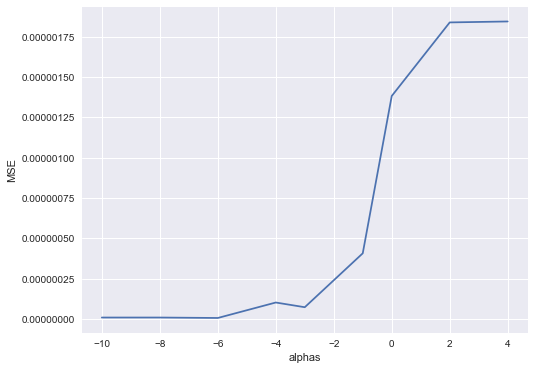

In [468]:
alphas=[1e-10,1e-8,1e-6,1e-4,1e-3,1e-1,1,100,10000]

# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(),a))
    
#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [469]:
#Find R-squared with Ridge cross validation
rcv = RidgeCV(alphas=(1e-3, 1e-2, 1e-1), cv=5)
rcv.fit(X_trans, y_trans)
rcv.score(X_trans, y_trans)

0.94396480764509094

#### Lasso

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


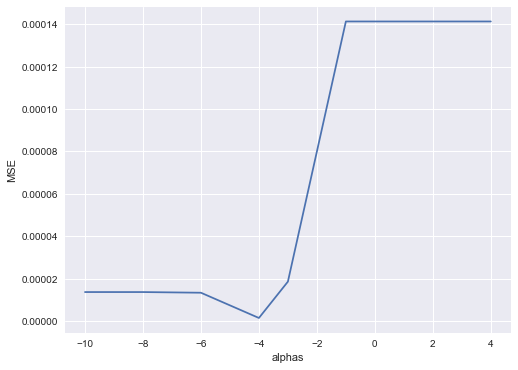

In [322]:
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Lasso(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [323]:
#find R-squared with Lasso cross validation
lcv = LassoCV(alphas=(1e-5, 1e-4, 1e-3), cv=5)
lcv.fit(X_trans, y_trans)
lcv.score(X_trans, y_trans)

0.93648533437292214

#### Elastic Net

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


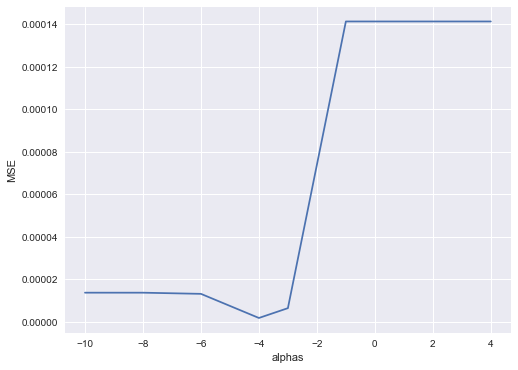

In [324]:
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(ElasticNet(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [325]:
#find R-squared with Elastic Net cross validation
ecv = ElasticNetCV(alphas=(1e-5, 1e-4, 1e-3), cv=5)
ecv.fit(X_trans, y_trans)
ecv.score(X_trans, y_trans)

0.93706618431972311

#### Ridge gave the best model with highest R2, alpha = 1e-4

In [470]:
#print intercept and coefficients
print(rcv.intercept_, rcv.coef_)

0.0401963706239 [-0.1997769   0.11221041 -0.19123583  0.25150237  0.74002124]


In [471]:
#put coefficients in dataframe
zipped = zip(X_trans.columns, rcv.coef_)
features = sorted(zipped, key = lambda t:t[1], reverse=True)
features

[('Years_Since_1950', 0.74002123619459192),
 ('Growing_Days', 0.25150237282643023),
 ('Heating_Days', 0.11221040678985177),
 ('Cooling_Days', -0.19123582605747863),
 ('Population', -0.19977689567098333)]

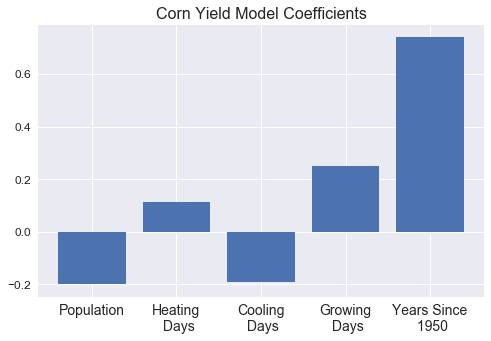

In [480]:
#plot a bar graph of the coefficients
name = [1, 2, 3, 4, 5]
name_trans = ['Population', 'Heating\n Days', 'Cooling\n Days', 'Growing\n Days', 'Years Since\n 1950']
coefficients = rcv.coef_
plt.subplots(1, 1, figsize=(8,5))
plt.bar(name, coefficients)
plt.xticks(name, name_trans, fontsize=14)
plt.yticks(fontsize=12)
plt.title('Corn Yield Model Coefficients', fontsize=16)
plt.show()

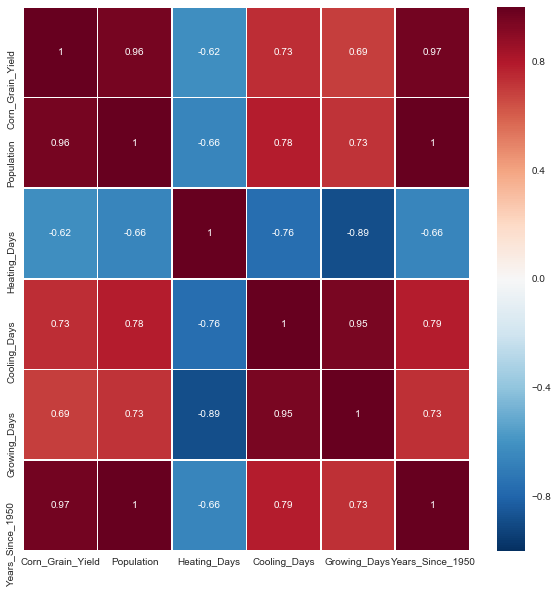

In [350]:
#Heat map of variable correlations
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corn_trans.corr(),annot=True,linewidth=0.5, ax=ax)

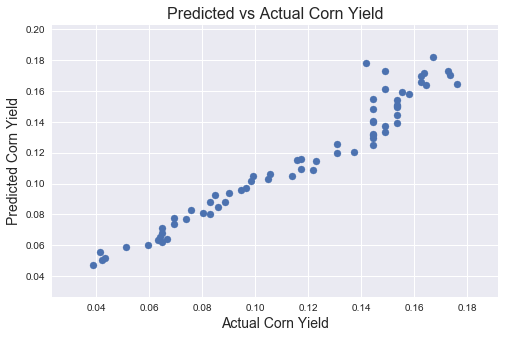

In [486]:
#Plot actual vs predict corn yield
plt.subplots(figsize=(8,5))
plt.scatter(y_trans,rcv.predict(X_trans));
plt.xlabel('Actual Corn Yield', fontsize=14);
plt.ylabel('Predicted Corn Yield', fontsize=14);
plt.title('Predicted vs Actual Corn Yield', fontsize=16)

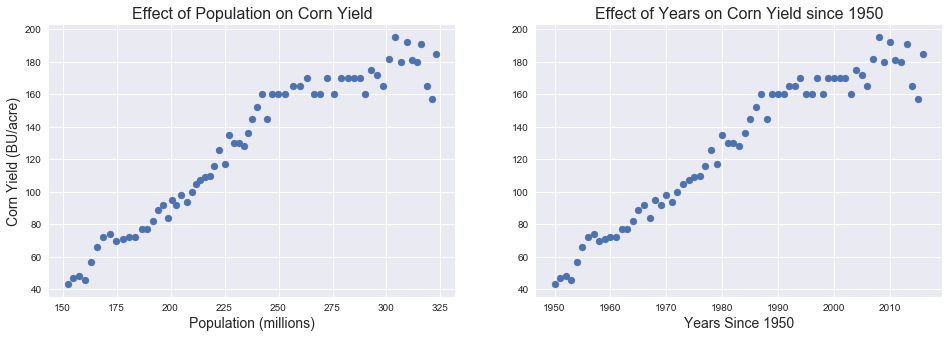

In [519]:
#Plot corn yield vs population and years
plt.subplots(1, 2, figsize=(16,5))
plt.subplot(121)
plt.scatter(df_corn_weather3['Population'], df_corn_weather3['Corn_Grain_Yield'])
plt.xlabel('Population (millions)', fontsize=14)
plt.ylabel('Corn Yield (BU/acre)', fontsize=14)
plt.title('Effect of Population on Corn Yield', fontsize=16)
plt.subplot(122)
plt.scatter(df_corn_weather3['Years_Since_1950']+1950, df_corn_weather3['Corn_Grain_Yield'])
plt.xlabel('Years Since 1950', fontsize=14)
plt.title('Effect of Years on Corn Yield since 1950', fontsize=16)

#### Population and years are strongly correlated to corn yield, so they are the best predictors

But we want to see how weather affects corn yield...

## Corn Model Repeat (with ONLY weather variables)

In [367]:
df_corn_weather6 = df_corn_weather.drop(['Population', 'Years_Since_1950'],1)
lsm = smf.ols('Corn_Grain_Yield ~ Cooling_Days + Mean_Temperature + Growing_Days + Max_Temperature+ Min_Temperature + Precipitation + Dew_Point + Sea_Level_Pressure + Wind + Heating_Days', data=df_corn_weather6)
fit1 = lsm.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Corn_Grain_Yield   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     10.93
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           5.07e-10
Time:                        16:33:01   Log-Likelihood:                -312.78
No. Observations:                  67   AIC:                             647.6
Df Residuals:                      56   BIC:                             671.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.184e+04   8113.762     -2.692      0.009   -3.81e+04   -5588.554
Cooling_Days           5.3148      2.917      1.822      0.074      -0.528      11.158
Mean_Temperature      13.1964     30.150      0.438      0.663     -47.200      73.593
Growing_Days          -3.1602      1.465     -2.157      0.035      -6.095      -0.225
Max_Temperature       -4.0798      2.345     -1.740      0.087      -8.777       0.617
Min_Temperature       -0.4193      1.840     -0.228      0.821      -4.105       3.266
Precipitation         14.8634     13.954      1.065      0.291     -13.090      42.816
Dew_Point              0.2739      0.245      1.118      0.268      -0.217       0.764
Sea_Level_Pressure   725.1462    262.817      2.759      0.008     198.660    1251.633
Wind                  -5.3214      8.181     -0.650      0.518     -21.709      11.066
Heating_Days          -1.4490      2.627     -0.552      0.583      -6.712       3.814
==============================================================================
Omnibus:                        1.028   Durbin-Watson:                   1.150
Prob(Omnibus):                  0.598   Jarque-Bera (JB):                0.965
Skew:                          -0.099   Prob(JB):                        0.617
Kurtosis:                       2.446   Cond. No.                     1.42e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [368]:
#find R-squared with cross validation for better prediction
c_model6 = LinearRegression()
X = df_corn_weather6.iloc[:,1:]
y = df_corn_weather6.iloc[:,0]

cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(c_model6, X, y, cv=cross_valiator)
np.round(scores.mean(), 2)

0.27000000000000002

Decent score was too good to be true according to CV...There's must have been overfitting, so let's remove variables

In [369]:
df_corn_weather7 = df_corn_weather6.drop(['Mean_Temperature', 'Min_Temperature', 'Wind', 'Heating_Days'],1)
lsm = smf.ols('Corn_Grain_Yield ~ Cooling_Days + Growing_Days + Max_Temperature + Precipitation + Dew_Point + Sea_Level_Pressure', data=df_corn_weather7)
fit2 = lsm.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Corn_Grain_Yield   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     15.82
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           8.45e-11
Time:                        16:37:24   Log-Likelihood:                -317.26
No. Observations:                  67   AIC:                             648.5
Df Residuals:                      60   BIC:                             664.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.756e+04   7814.620     -2.247      0.028   -3.32e+04   -1925.570
Cooling_Days           4.1052      1.200      3.421      0.001       1.705       6.506
Growing_Days          -0.3756      0.741     -0.507      0.614      -1.857       1.106
Max_Temperature       -2.5456      2.221     -1.146      0.256      -6.989       1.898
Precipitation         27.8331     12.452      2.235      0.029       2.926      52.740
Dew_Point              0.0944      0.233      0.405      0.687      -0.372       0.561
Sea_Level_Pressure   589.2650    260.000      2.266      0.027      69.187    1109.343
==============================================================================
Omnibus:                        0.410   Durbin-Watson:                   1.085
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.571
Skew:                           0.137   Prob(JB):                        0.752
Kurtosis:                       2.640   Cond. No.                     1.30e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [370]:
#find R-squared with cross validation
c_model7 = LinearRegression()
X = df_corn_weather7.iloc[:,1:]
y = df_corn_weather7.iloc[:,0]

cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(c_model7, X, y, cv=cross_valiator)
np.round(scores.mean(), 2)

0.25

R-squared is worse....but normality is improving..keep removing more variables?

In [372]:
df_corn_weather8 = df_corn_weather7.drop(['Growing_Days', 'Dew_Point'],1)
lsm = smf.ols('Corn_Grain_Yield ~ Cooling_Days + Max_Temperature + Precipitation + Sea_Level_Pressure', data=df_corn_weather8)
fit3 = lsm.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Corn_Grain_Yield   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     24.31
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           3.99e-12
Time:                        16:40:32   Log-Likelihood:                -317.45
No. Observations:                  67   AIC:                             644.9
Df Residuals:                      62   BIC:                             655.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.784e+04   7600.864     -2.348      0.022    -3.3e+04   -2650.744
Cooling_Days           3.5583      0.448      7.950      0.000       2.664       4.453
Max_Temperature       -2.5042      2.173     -1.152      0.254      -6.848       1.840
Precipitation         29.3187     10.945      2.679      0.009       7.439      51.198
Sea_Level_Pressure   599.4004    253.501      2.364      0.021      92.659    1106.142
==============================================================================
Omnibus:                        0.502   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.778   Jarque-Bera (JB):                0.620
Skew:                           0.184   Prob(JB):                        0.734
Kurtosis:                       2.705   Cond. No.                     2.62e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [373]:
c_model8 = LinearRegression()
X = df_corn_weather8.iloc[:,1:]
y = df_corn_weather8.iloc[:,0]

cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(c_model8, X, y, cv=cross_valiator)
np.round(scores.mean(), 2)

0.34999999999999998

Best score yet! Remove the variable Max_Temperature

In [374]:
df_corn_weather9 = df_corn_weather8.drop(['Max_Temperature'],1)
lsm = smf.ols('Corn_Grain_Yield ~ Cooling_Days + Precipitation + Sea_Level_Pressure', data=df_corn_weather9)
fit4 = lsm.fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Corn_Grain_Yield   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     31.80
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           1.22e-12
Time:                        16:42:02   Log-Likelihood:                -318.16
No. Observations:                  67   AIC:                             644.3
Df Residuals:                      63   BIC:                             653.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.756e+04   7616.677     -2.306      0.024   -3.28e+04   -2342.189
Cooling_Days           3.2179      0.337      9.544      0.000       2.544       3.892
Precipitation         29.9458     10.960      2.732      0.008       8.043      51.848
Sea_Level_Pressure   582.5410    253.736      2.296      0.025      75.489    1089.593
==============================================================================
Omnibus:                        0.649   Durbin-Watson:                   1.027
Prob(Omnibus):                  0.723   Jarque-Bera (JB):                0.761
Skew:                           0.127   Prob(JB):                        0.684
Kurtosis:                       2.544   Cond. No.                     1.54e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [375]:
c_model9 = LinearRegression()
X = df_corn_weather9.iloc[:,1:]
y = df_corn_weather9.iloc[:,0]

cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(c_model9, X, y, cv=cross_valiator)
np.round(scores.mean(), 2)

0.37

Highest score of all models so far! P-values and normality all look very good.

### Normalization and Regularization

In [523]:
#normalize data for df_corn_weather9
corn_trans2 = preprocessing.normalize(df_corn_weather9, axis =0)

corn_trans2= pd.DataFrame(corn_trans2,columns=df_corn_weather9.columns)

y_trans = corn_trans2['Corn_Grain_Yield']
X_trans = corn_trans2.drop(['Corn_Grain_Yield'],1)

#### Ridge

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


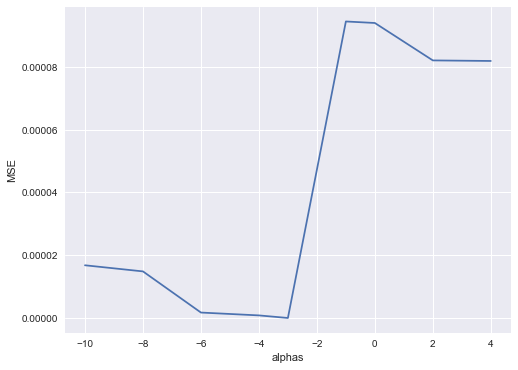

In [377]:
alphas=[1e-10,1e-8,1e-6,1e-4,1e-3,1e-1,1,100,10000]
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.3)

# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(),a))
    
#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [493]:
#find R-squared with Ridge CV
rcv = RidgeCV(alphas=(1e-5, 1e-4, 1e-3), cv=5)
rcv.fit(X_trans, y_trans)
rcv.score(X_trans, y_trans)

0.56913075367461485

#### Lasso

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


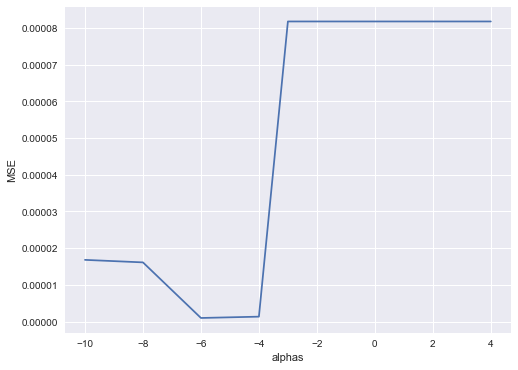

In [379]:
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Lasso(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [460]:
#Find R-squared with Lasso CV
lcv = LassoCV(alphas=(1e-6, 1e-5, 1e-4), cv=5)
lcv.fit(X_trans, y_trans)
lcv.score(X_trans, y_trans)

0.56899511014193616

#### Elastic Net

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


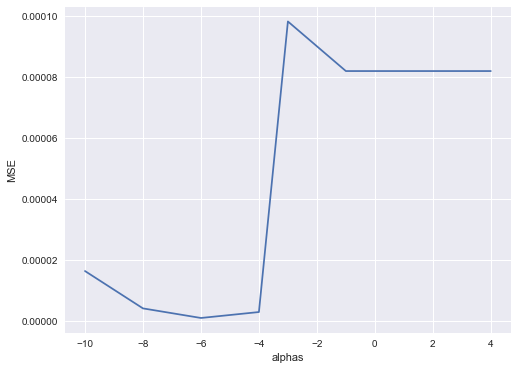

In [381]:
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(ElasticNet(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [461]:
#Find R-squared with Elastic Net CV
ecv = ElasticNetCV(alphas=(1e-6, 1e-5, 1e-4), cv=5)
ecv.fit(X_trans, y_trans)
ecv.score(X_trans, y_trans)

0.56899437890557403

#### Ridge regularization gave the highest R2 value, alpha = 1e-4

In [494]:
print(rcv.intercept_, rcv.coef_)

-0.101808409414 [ 1.4616871   0.08337722  0.27480401]


In [495]:
#put coefficients in dataframe
zipped = zip(X_trans.columns, rcv.coef_)
features = sorted(zipped, key = lambda t:t[1], reverse=True)
features

[('Cooling_Days', 1.4616871011137331),
 ('Sea_Level_Pressure', 0.27480401434500235),
 ('Precipitation', 0.083377219225245394)]

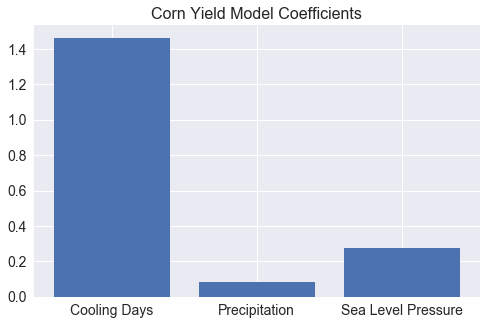

In [496]:
#plot a bar graph of the coefficients
name = [1, 2, 3]
name_trans = ['Cooling Days', 'Precipitation', 'Sea Level Pressure']
coefficients = rcv.coef_
plt.subplots(figsize=(8,5))
plt.bar(name, coefficients)
plt.xticks(name, name_trans, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Corn Yield Model Coefficients', fontsize=16)
plt.show()

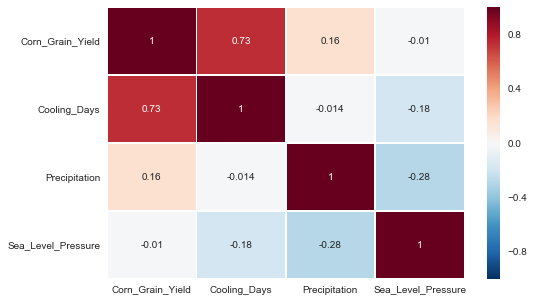

In [497]:
#Heat map of variable correlations
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(corn_trans2.corr(),annot=True,linewidth=0.5, ax=ax)

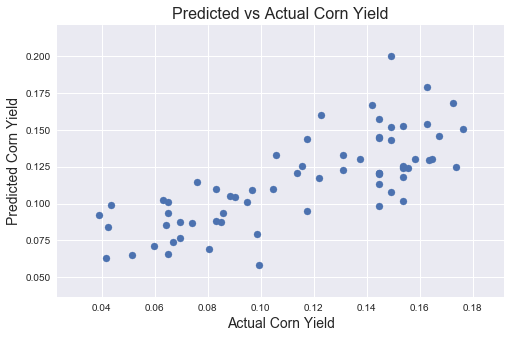

In [498]:
#Plot actual vs predict corn yield
plt.subplots(1,1,figsize=(8,5))
plt.scatter(y_trans, rcv.predict(X_trans))
plt.xlabel('Actual Corn Yield', fontsize=14)
plt.ylabel('Predicted Corn Yield', fontsize=14)
plt.title('Predicted vs Actual Corn Yield', fontsize=16)

Pretty well distributed with some linear correlation..now plot individual features against corn yield

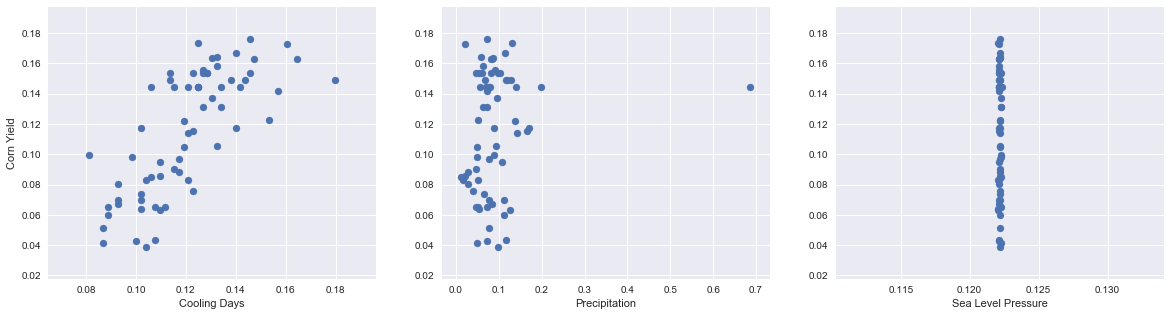

In [392]:
#Plot corn yield vs features
plt.subplots(1,3, figsize=(20,5))
plt.subplot(131)
plt.scatter(X_trans['Cooling_Days'],y_trans)
plt.xlabel('Cooling Days')
plt.ylabel('Corn Yield')
plt.subplot(132)
plt.scatter(X_trans['Precipitation'], y_trans)
plt.xlabel('Precipitation')
plt.subplot(133)
plt.scatter(X_trans['Sea_Level_Pressure'], y_trans)
plt.xlabel('Sea Level Pressure');

#### Uh oh....nothing really changes for sea level pressure.. let's remove that variable

In [438]:
df_corn_weather10 = df_corn_weather9.drop(['Sea_Level_Pressure'],1)
lsm = smf.ols('Corn_Grain_Yield ~ Cooling_Days + Precipitation', data=df_corn_weather10)
fit5 = lsm.fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Corn_Grain_Yield   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     42.25
Date:                Thu, 20 Jul 2017   Prob (F-statistic):           2.01e-12
Time:                        17:47:00   Log-Likelihood:                -320.85
No. Observations:                  67   AIC:                             647.7
Df Residuals:                      64   BIC:                             654.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -76.2141     22.498     -3.388      0.001    -121.159     -31.270
Cooling_Days      3.0689      0.342      8.980      0.000       2.386       3.752
Precipitation    22.6277     10.831      2.089      0.041       0.991      44.265
==============================================================================
Omnibus:                        2.117   Durbin-Watson:                   0.924
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.382
Skew:                          -0.022   Prob(JB):                        0.501
Kurtosis:                       2.298   Cond. No.                         402.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [439]:
c_model10 = LinearRegression()
X = df_corn_weather10.iloc[:,1:]
y = df_corn_weather10.iloc[:,0]

cross_valiator = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(c_model10, X, y, cv=cross_valiator)
np.round(scores.mean(), 2)

0.38

Slightly better than the original model... now apply Ridge regularization

In [440]:
#Normalize variables
corn_trans3 = preprocessing.normalize(df_corn_weather10, axis =0)

corn_trans3= pd.DataFrame(corn_trans3,columns=df_corn_weather10.columns)

y_trans = corn_trans3['Corn_Grain_Yield']
X_trans = corn_trans3.drop(['Corn_Grain_Yield'],1)

/Users/kevinzhao/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


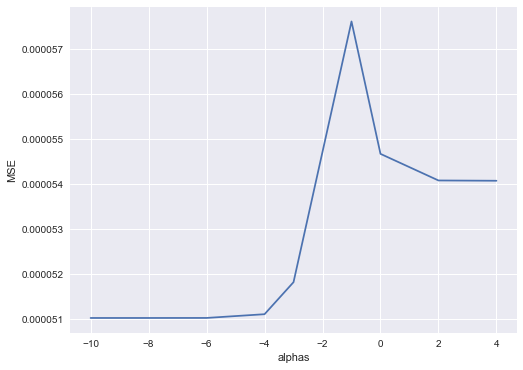

In [441]:
alphas=[1e-10,1e-8,1e-6,1e-4,1e-3,1e-1,1,100,10000]
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.3)

# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(),a))
    
#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [442]:
rcv_refined = RidgeCV(alphas=(1e-5, 1e-4, 1e-3), cv=5)
rcv_refined.fit(X_trans, y_trans)
rcv_refined.score(X_trans, y_trans)

0.56899668445723295

Pretty much identical R2 with new model, but let's use this one

In [503]:
rcv_refined.intercept_

-0.068800738163365183

In [443]:
#put coefficients in dataframe
zipped = zip(X_trans.columns, rcv_refined.coef_)
features = sorted(zipped, key = lambda t:t[1], reverse=True)


[('Cooling_Days', 1.4663933683564194), ('Precipitation', 0.083353464809292982)]

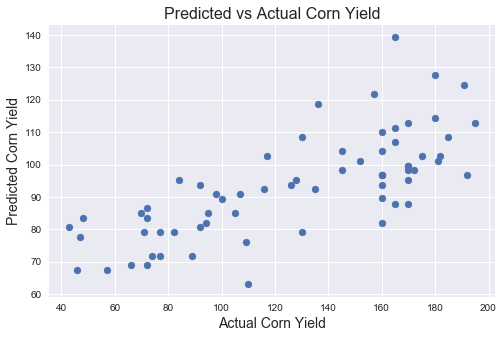

In [499]:
#Plot actual vs predict corn yield
y = df_corn_weather10['Corn_Grain_Yield']
X = df_corn_weather10.drop(['Corn_Grain_Yield'],1)
plt.subplots(1,1,figsize=(8,5))
plt.scatter(y, rcv_refined.predict(X))
plt.xlabel('Actual Corn Yield', fontsize=14)
plt.ylabel('Predicted Corn Yield', fontsize=14)
plt.title('Predicted vs Actual Corn Yield', fontsize=16)

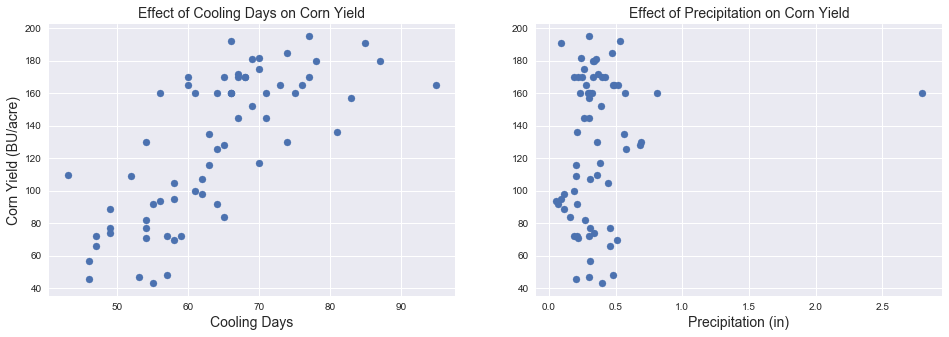

In [522]:
#Plot corn yield vs features
plt.subplots(1,2, figsize=(16,5))
plt.subplot(121)
plt.scatter(X['Cooling_Days'],y)
plt.xlabel('Cooling Days', fontsize=14)
plt.ylabel('Corn Yield (BU/acre)', fontsize=14)
plt.title('Effect of Cooling Days on Corn Yield', fontsize=14)
plt.subplot(122)
plt.scatter(X['Precipitation'],y)
plt.xlabel('Precipitation (in)', fontsize=14)
plt.title('Effect of Precipitation on Corn Yield', fontsize=14);

Some correlation for Cooling Days with randomness. Not much variation in precipitation.

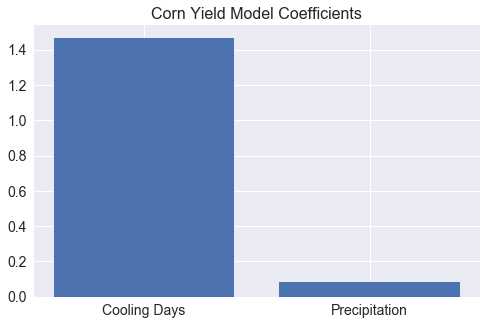

In [502]:
#plot a bar graph of the coefficients
name = [1, 2]
name_trans = ['Cooling Days', 'Precipitation']
coefficients = rcv_refined.coef_
plt.subplots(figsize=(8,5))
plt.bar(name, coefficients)
plt.xticks(name, name_trans, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Corn Yield Model Coefficients', fontsize=16)
plt.show()

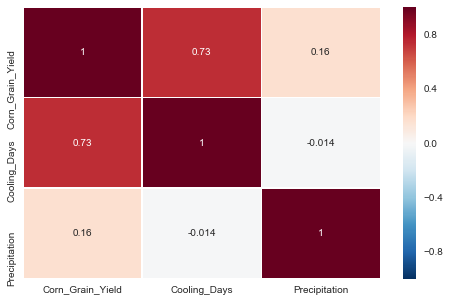

In [506]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(corn_trans3.corr(),annot=True,linewidth=0.5, ax=ax)

No significant correlation between variables

----------